In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable

import numpy as np
import cvxpy as cp

from MPC_prob import MPC

from utils import *
import pickle, os
from tqdm import tqdm
from para import paraset
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'#不设这个解不出#

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## shortest path generate horizon

In [18]:
# set parameters and save at MPC.config
N =8
# paraset(N=8,n_obs=5,Qs=1,Rs=0,num_probs=20000,obs_fix=True,xg_fix=False)

In [16]:
# load setting file and plot obstacles
#pass the value from config to dict and para
relative_path = os.getcwd()
dataset_name = 'STL_horizon_{}'.format(N)
# dataset_name = 'NSTL_{}_horizon_{}'.format(Qs, N)
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')

# config = [dataset_name, [prob_params] ,sampled_params]
outfile = open(config_fn,"rb")
config=pickle.load(outfile)
outfile.close()

train_fn = 'train_horizon_{}.p'.format(N)
train_fn = os.path.join(relative_path, 'data', dataset_name, train_fn)
test_fn = 'test_horizon_{}.p'.format(N)
test_fn = os.path.join(relative_path, 'data', dataset_name, test_fn)

all_params = ['N', 'Ak', 'Bk', 'Q', 'R', 'n_obs', \
            'posmin', 'posmax', 'velmin', 'velmax', \
            'umin', 'umax']

param_dict={}
i=0
len_para = len(all_params)
for param in all_params:
    param_dict[param]= config[1][i]
    i+=1
    if i == len_para:
        break

N = param_dict['N']
Ak = param_dict['Ak']
Bk = param_dict['Bk']
Q = param_dict['Q']
R = param_dict['R']
n_obs = param_dict['n_obs']
umin = param_dict['umin']
umax = param_dict['umax']
sampled_params = config[2]
n_obs = config[3]
num_probs = config[4]
border_size = config[5]
box_buffer = config[6]
min_box_size = config[7]
max_box_size = config[8]
posmin = config[9]
posmax = config[10]
velmin = config[11]
velmax = config[12]
n = config[13]
m= config[14]

obs_fix = config[15]
xg_fix = config[16]
if obs_fix:
    obstacles = config[-1]

config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')#

prob = MPC(config=config_fn)
#create numpy containers for data: (params, x, u, y, J*, solve_time)
params = {}
if 'x0' in sampled_params:
    params['x0'] = np.zeros((num_probs,2*n))
if 'xg' in sampled_params:
    params['xg'] = np.zeros((num_probs,2*n))
if 'obstacles' in sampled_params:
    params['obstacles'] = np.zeros((num_probs, 4, n_obs))

X = np.zeros((num_probs, 2*n, N));
U = np.zeros((num_probs, m, N-1))
Y = np.zeros((num_probs, 4*n_obs, N-1)).astype(int)
Z = np.zeros((num_probs, 2*n_obs, N-1)).astype(int)

costs = np.zeros(num_probs)
solve_times = np.zeros(num_probs)

prob.sampled_params = ['x0', 'xg', 'obstacles']

#solving MICP
ii_toggle = 0
obs_new_ct = 5
ii=0
obstacles = config[-1]

if obs_fix:
    for ii in tqdm(range(num_probs)):
        x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
        params['obstacles'][ii,:] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
        p_dict = {}
        params['x0'][ii,:] = x0
        xg= findIC(obstacles, posmin, posmax, velmin, velmax)
        params['xg'][ii,:] = xg

        p_dict['x0'] = params['x0'][ii,:]
        p_dict['xg'] = params['xg'][ii,:]
        p_dict['obstacles'] = params['obstacles'][ii,:]

        prob_success = False
        try:
            # with time_limit(20):
            prob_success, cost, solve_time, optvals = prob.solve_stl(p_dict, solver=cp.GUROBI)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print('solver failed at '.format(ii))

        if prob_success:
            costs[ii] = cost; solve_times[ii] = solve_time
            X[ii,:,:], U[ii,:,:], Y[ii,:,:], Z[ii,:,:] = optvals
            ii += 1
else:
    print('choose to fix obstalce')
num_train = int(num_probs*0.9)
arr = np.arange(num_probs)
np.random.shuffle(arr)

if 'x0' in sampled_params:
    params['x0'] = params['x0'][arr]
if 'xg' in sampled_params:
    params['xg'] = params['xg'][arr]
if 'obstacles' in sampled_params:
    params['obstacles'] = params['obstacles'][arr]

costs = costs[arr]
solve_times = solve_times[arr]


X = X[arr]
U = U[arr]
Y = Y[arr]
Z = Z[arr]

train_params = {}; test_params = {}
if 'x0' in sampled_params:
    train_params['x0'] = params['x0'][:num_train,:]
    test_params['x0'] = params['x0'][num_train:,:]
if 'obstacles' in sampled_params:
    train_params['obstacles'] = params['obstacles'][:num_train,:]
    test_params['obstacles'] = params['obstacles'][num_train:,:]
if 'xg' in sampled_params:
    train_params['xg'] = params['xg'][:num_train,:]
    test_params['xg'] = params['xg'][num_train:,:]

train_data = [train_params]
train_data += [X[:num_train,:,:], U[:num_train,:,:], Y[:num_train,:,:],Z[:num_train,:,:]]
train_data += [costs[:num_train], solve_times[:num_train]]

test_data = [test_params]
test_data += [X[num_train:,:,:], U[num_train:,:,:], Y[num_train:,:,:], Z[:num_train,:,:]]
test_data += [costs[num_train:], solve_times[num_train:]]

train_file = open(train_fn,'wb')
pickle.dump(train_data,train_file); train_file.close()

test_file = open(test_fn, 'wb')
pickle.dump(test_data,test_file); test_file.close()

  0%|          | 3/20000 [00:01<3:22:48,  1.64it/s]


KeyboardInterrupt: 

## 加载训练数据查看情况

In [19]:
#pass the value from config to dict and para
relative_path = os.getcwd()
dataset_name = 'STL_horizon_{}'.format(N)
config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')


prob = MPC(config=config_fn) #use default config, pass different config file oth.

relative_path = os.getcwd()
dataset_fn = relative_path + '/data/' + dataset_name

##load train data
train_file = open(dataset_fn+'/train_horizon_{}.p'.format(N),'rb')
# train_file = open(dataset_fn+'/train.p','rb')
train_data = pickle.load(train_file)
p_train, x_train, u_train, y_train,z_train, c_train, times_train = train_data
train_file.close()

x_train = train_data[1] #X sequence
y_train = train_data[3] #Y sequence

##load test data
test_file = open(dataset_fn+'/test_horizon_{}.p'.format(N),'rb')
# test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test,z_test, c_test, times_test = test_data
test_file.close()

In [24]:
from solvers.OMISTL import OMISTL

system = 'free_flyer'
prob_features = ['x0','xg','obstacles']
# prob_features = ['x0','xg','obstacles_map']

OMISTL_obj = OMISTL(system, prob, prob_features)

n_features = 33
OMISTL_obj.construct_strategies(n_features, train_data)
print(OMISTL_obj.n_strategies)

707


In [38]:
def train_horizon_N(N, device_id=0):
    relative_path = os.getcwd()
    config_fn = relative_path + '/config/STL_horizon_{}.p'.format(N)
    config_file = open(config_fn,'rb')
    config =  pickle.load(config_file)
    dataset_name = config[0]; config_file.close()

    dataset_fn = relative_path + '/data/' + dataset_name

    train_fn = os.path.join(dataset_fn, 'train_horizon_{}.p'.format(N))
    train_file = open(train_fn,'rb')
    train_data = pickle.load(train_file)
    train_file.close()
    x_train = train_data[1]
    y_train = train_data[3]

    test_fn = os.path.join(dataset_fn, 'test_horizon_{}.p'.format(N))
    test_file = open(test_fn,'rb')
    test_data = pickle.load(test_file)
    p_test, x_test, u_test, y_test,z_test, c_test, times_test = test_data
    test_file.close()

    n_test = x_test.shape[0]

    system = 'free_flyer'
    prob_features = ['x0', 'xg', 'obstacles']

    prob = MPC(config=config_fn)
    mlopt = OMISTL(system, prob, prob_features)

    n_features = 33
    mlopt.construct_strategies(n_features, train_data)

    print('Number of strategies for horizon {}: {}'.format(N, mlopt.n_strategies))

    mlopt.setup_network(device_id=device_id)
    mlopt.model_fn = 'D:\Curious\OMISTL\models/STL_horizon_{}.pt'.format(N)
    mlopt.training_params['TRAINING_ITERATIONS'] =500
    mlopt.train(train_data=train_data, verbose=True)

In [39]:
train_horizon_N(8)

Number of strategies for horizon 8: 707
loss:   2.4094128608703613,   acc:  0.46875
Done with epoch 0 in 6.235046863555908s
loss:   0.8400173187255859,   acc:  0.71875
Done with epoch 1 in 5.094435453414917s
loss:   2.069427967071533,   acc:  0.53125
loss:   1.2070969343185425,   acc:  0.6875
Done with epoch 2 in 5.203831434249878s
loss:   1.3285490274429321,   acc:  0.65625
Done with epoch 3 in 5.047436237335205s
loss:   1.150989055633545,   acc:  0.59375
loss:   1.7508950233459473,   acc:  0.5625
Done with epoch 4 in 5.250467538833618s
loss:   0.8006517291069031,   acc:  0.71875
Done with epoch 5 in 5.1724467277526855s
loss:   1.0837535858154297,   acc:  0.65625
Done with epoch 6 in 5.063223600387573s
loss:   1.0056769847869873,   acc:  0.625
loss:   1.1863396167755127,   acc:  0.625
Done with epoch 7 in 5.563173770904541s
loss:   0.6598049402236938,   acc:  0.8125
Done with epoch 8 in 5.109859943389893s
loss:   1.2113735675811768,   acc:  0.59375
loss:   1.6304033994674683,   acc:  

In [23]:
OMISTL_obj.setup_network()
fn_saved = 'D:\Curious\OMISTL/models/STL_horizon_{}.pt'.format(N)
# fn_saved = 'D:\Curious\CoCo-master\models\obs_fix_horizon_6.pt'
# fn_saved = 'mloptff_free_flyer_20200726_1455.pt'
OMISTL_obj.load_network(fn_saved)
OMISTL_obj.prob_features
OMISTL_obj.model

NameError: name 'OMISTL_obj' is not defined

In [7]:
outfile = open(config_fn,"rb")
config=pickle.load(outfile)
outfile.close()

velmin = -0.2
velmax = 0.2
posmin = np.zeros(2)

ft2m = 0.3048
posmax = ft2m*np.array([12.,9.])
max_box_size = 0.75
min_box_size = 0.25
box_buffer = 0.025
border_size = 0.05

obstacles = config[-1]
x0 = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)
xg = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)
# obstacles = \
#         random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)

In [8]:
p_test['obstacles'][4]

array([[1.25, 1.25, 0.3 , 2.5 , 2.9 ],
       [2.  , 1.75, 0.8 , 3.25, 3.25],
       [1.2 , 0.2 , 1.5 , 1.6 , 2.  ],
       [1.5 , 1.  , 2.  , 2.  , 2.25]])

In [9]:
sampled_params = ['x0', 'xg', 'obstacles']
sample_dists = {'x0': lambda: np.hstack((posmin + (posmax-posmin)*np.random.rand(2), \
               velmin + (velmax-velmin)*np.random.rand(2))) ,\
               'xg': lambda: np.hstack((0.9*posmax, np.zeros(2))), \
               'obstacles': lambda: random_obs(n_obs, posmin, posmax, border_size, box_buffer, min_box_size, max_box_size)}

# obstacles = sample_dists['obstacles']()

In [10]:
prob_success = False
while not prob_success:
    prob_params = {}
    idx = np.random.randint(test_data[1].shape[0])
    for k in p_test.keys():
        prob_params[k] = p_test[k][idx]
    # prob_params['obstacles'] =  np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
    # x0 = sample_dists['x0']()
    # xg = sample_dists['xg']()
    # prob_params['x0'] = x0
    # prob_params['xg'] = xg
    # prob_success, cost, total_time, optvals = coco_obj.problem.solve_stl(prob_params, solver=cp.MOSEK)
    prob_success, cost, total_time, n_evals, optvals,y_guess = coco_obj.forward(prob_params, solver=cp.MOSEK, max_evals=10)
    # prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(p_dict, solver=cp.GUROBI, max_evals=10)
    if prob_success:
        print('Found solution! ' + "n_evals = " + str(n_evals))
    else:
        print('Failed')
        infeasible = prob_params
        break

total_time

Found solution! n_evals = 1


0.21860473442077638

In [11]:
prob_params = {}
prob_params['x0'] = infeasible['x0']
prob_params['xg'] = infeasible['xg']
prob_params['obstacles'] = p_test['obstacles'][4]

# prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(prob_params, solver=cp.GUROBI, max_evals=10)
prob_success, cost, total_time, optvals = OMISTL_obj.problem.solve_stl(prob_params, solver=cp.GUROBI)
prob_success

NameError: name 'infeasible' is not defined

In [12]:
# Xopt = optvals[0]
n_obs=OMISTL_obj.problem.n_obs
obstacles = []
for ii_obs in range(n_obs):
    # obs = test_data[0]['obstacles'][idx][:,ii_obs]
    obs = prob_params['obstacles'][:,ii_obs]
    obstacles.append(obs)

# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
x0 = prob_params['x0']
xg = prob_params['xg']


if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='red',ec="red")
    plt.gca().add_patch(circle)


    plt.plot(xg[0],xg[1],'sb')
    # plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#用箭头表示#
    # for jj in range(N):
    #     circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.02, fc='blue',ec="blue")
    #     plt.gca().add_patch(circle)

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

KeyError: 'obstacles'

In [61]:
p_test

{'x0': array([[ 1.64955507,  2.08817662, -0.14252453,  0.1634465 ],
        [ 3.61323856,  2.61109489,  0.07947994, -0.16495669],
        [ 3.31490901,  0.54036996, -0.04705142, -0.08446038],
        ...,
        [ 2.93079433,  1.23160593, -0.05885706, -0.10859127],
        [ 0.65639585,  0.37323605, -0.18943364,  0.17043649],
        [ 1.88858042,  1.99928769, -0.19953776, -0.02316986]]),
 'obstacles': array([[[1.25, 1.25, 0.3 , 2.5 , 2.9 ],
         [2.  , 1.75, 0.8 , 3.25, 3.25],
         [1.2 , 0.2 , 1.5 , 1.6 , 2.  ],
         [1.5 , 1.  , 2.  , 2.  , 2.25]],
 
        [[1.25, 1.25, 0.3 , 2.5 , 2.9 ],
         [2.  , 1.75, 0.8 , 3.25, 3.25],
         [1.2 , 0.2 , 1.5 , 1.6 , 2.  ],
         [1.5 , 1.  , 2.  , 2.  , 2.25]],
 
        [[1.25, 1.25, 0.3 , 2.5 , 2.9 ],
         [2.  , 1.75, 0.8 , 3.25, 3.25],
         [1.2 , 0.2 , 1.5 , 1.6 , 2.  ],
         [1.5 , 1.  , 2.  , 2.  , 2.25]],
 
        ...,
 
        [[1.25, 1.25, 0.3 , 2.5 , 2.9 ],
         [2.  , 1.75, 0.8 , 3.25, 3.2

In [14]:
n_succ = 0
count = 0
n_test = 500
gurobi_mlopt_fail = 0

costs_gurobi = []
total_time_gurobi = []
num_solves_gurobi = []

cost_ratios_gurobi = []
costs_ip = []
total_time_ip = []
num_solves_ip = []
gurobi_fail_list = []
mlopt_fail = 0

for ii in range(n_test):
    if ii % 50 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, optvals = OMISTL_obj.problem.solve_stl(prob_params, solver=cp.MOSEK)
        if prob_success:
            n_succ += 1
            costs_gurobi += [cost]
            total_time_gurobi += [total_time]
            num_solves_gurobi += [n_evals]

            true_cost = c_test[ii]
            costs_ip += [true_cost]
            total_time_ip += [times_test[ii]]
            cost_ratios_gurobi += [cost / true_cost]
        else:
            mlopt_fail += 1
            gurobi_fail_list += [ii]
        count += 1
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('Solver failed at {}'.format(ii))
        gurobi_mlopt_fail += 1
        continue

costs_gurobi = np.array(costs_gurobi)
cost_ratios_gurobi = np.array(cost_ratios_gurobi)
total_time_gurobi = np.array(total_time_gurobi)
num_solves_gurobi = np.array(num_solves_gurobi, dtype=int)

costs_ip = np.array(costs_ip)
total_time_ip = np.array(total_time_ip)
gurobi_percentage = 100 * float(n_succ) / float(count)
num_solves_ip = np.array(num_solves_ip, dtype=int)

0 / 500
50 / 500
100 / 500
150 / 500
200 / 500
250 / 500
300 / 500
350 / 500
400 / 500
450 / 500


In [15]:
sum(total_time_gurobi)/472

0.39593008474576263

In [16]:
print(gurobi_percentage)
print(gurobi_fail_list)
# print(list(set(C)))

94.4
[32, 66, 107, 118, 144, 150, 162, 166, 179, 189, 201, 219, 221, 231, 271, 289, 318, 320, 348, 362, 400, 426, 427, 430, 439, 442, 482, 491]


Feasible: True
Start(red point): [2.22007105 1.96051899 0.19864914 0.1063487 ]
End(blue point): [ 0.93905872  1.59938895 -0.12678553  0.01863195]


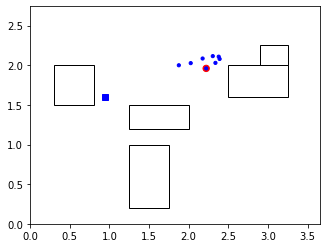

In [23]:
for k in p_test.keys():
        prob_params[k] = p_test[k][215]

# prob_success, cost, total_time, optvals = coco_obj.problem.solve_stl(prob_params, solver=cp.MOSEK)
prob_success, cost, total_time,n_evals, optvals,y_guess = OMISTL_obj.forward(prob_params, max_evals=10, solver=cp.MOSEK)
print('Feasible: '+str(prob_success))

if prob_success:
    Xopt = optvals[0]

obstacles = []
for ii_obs in range(n_obs):
    # obs = test_data[0]['obstacles'][idx][:,ii_obs]
    obs = prob_params['obstacles'][:,ii_obs]
    obstacles.append(obs)

# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
x0 = prob_params['x0']
xg = prob_params['xg']
print('Start(red point): '+ str(x0))
print('End(blue point): '+ str(xg))


if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='white', ec='black')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='red',ec="red")
    plt.gca().add_patch(circle)


    plt.plot(xg[0],xg[1],'sb')
    # plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#用箭头表示#
    if prob_success:
        for jj in range(N):
            circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.02, fc='blue',ec="blue")
            plt.gca().add_patch(circle)

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

In [19]:
n_succ = 0
count = 0
n_test = 500
gurobi_mlopt_fail = 0

costs_coco = []
total_time_coco = []
num_solves_coco = []

cost_ratios_coco = []
costs_ip = []
total_time_ip = []
num_solves_ip = []
fail_list = []
mlopt_fail = 0

for ii in range(n_test):
    if ii % 50 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals, optvals,y_guess = coco_obj.forward(prob_params, max_evals=10, solver=cp.MOSEK)

        if prob_success:
            n_succ += 1
            costs_coco += [cost]
            total_time_coco += [total_time]
            num_solves_coco += [n_evals]

            true_cost = c_test[ii]
            costs_ip += [true_cost]
            total_time_ip += [times_test[ii]]

            cost_ratios_coco += [cost / true_cost]
        else:
            mlopt_fail += 1
            fail_list += [ii]
        count += 1
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('Solver failed at {}'.format(ii))
        gurobi_mlopt_fail += 1
        continue

costs_coco = np.array(costs_coco)
cost_ratios_coco = np.array(cost_ratios_coco)
total_time_coco = np.array(total_time_coco)
num_solves_coco = np.array(num_solves_coco, dtype=int)

costs_ip = np.array(costs_ip)
total_time_ip = np.array(total_time_ip)
stl_percentage = 100 * float(n_succ) / float(count)
num_solves_ip = np.array(num_solves_ip, dtype=int)

0 / 500
Solver failed at 20
Solver failed at 171
Solver failed at 188
Solver failed at 277
Solver failed at 324
Solver failed at 363
Solver failed at 447


In [44]:
num_optimal = 0
for i in range(448):
    if cost_ratios_coco[i] <= 1.01:
        num_optimal += 1
print('optimal percentage: '+ str(num_optimal/len(cost_ratios_coco)))
print('number of feasible solutions: '+ str(stl_percentage))
print('avarage solve time: '+ str(sum(total_time_coco)/len(cost_ratios_coco)))

optimal percentage: 0.9174107142857143
number of feasible solutions: 90.87221095334685
avarage solve time: 0.015313893654516759


In [25]:
from store_file import store_infeasible

solution_infea = {'stl_infea':fail_list, 'gurobi_infea':gurobi_fail_list}
file_path = store_infeasible(solution_infea,dataset_name)
outfile = open(file_path,"rb")
solution_infea = pickle.load(outfile)
outfile.close()

NameError: name 'fail_list' is not defined

In [146]:
%pprint

Pretty printing has been turned OFF


## Load config file

In [121]:
relative_path = os.getcwd()

config_fn = os.path.join(relative_path, 'config', dataset_name+'.p')#设置文件地址，config = [dataset_name, prob_params, sampled_params]#
config_file = open(config_fn,'rb')
config = pickle.load(config_file)
dataset_name = config[0]
prob_params = config[1]
sampled_params = config[2];
config_file.close()#读取设置#

p=prob_params
p_dict = {}


all_params = ['N', 'Ak', 'Bk', 'Q', 'R', 'n_obs', \
            'posmin', 'posmax', 'velmin', 'velmax', \
            'umin', 'umax']

param_dict={}
i=0
len_para = len(all_params)
for param in all_params:
    param_dict[param]= config[1][i]
    i+=1
    if i == len_para:
        break

N = param_dict['N']
Ak = param_dict['Ak']
Bk = param_dict['Bk']
Q = param_dict['Q']
R = param_dict['R']
n_obs = param_dict['n_obs']
umin = param_dict['umin']
umax = param_dict['umax']

# num_probs = config[3]
# border_size = config[4]
# box_buffer = config[5]
# min_box_size = config[6]
# max_box_size = config[7]
# posmin = config[8]
# posmax = config[9]
# velmin = config[10]
# velmax = config[11]
# n = config[12]
# m= config[13]
#
# obs_fix = config[14]
# xg_fix = config[15]
# if obs_fix:
#     obstacles = config[16]

#
# x0 = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)
# xg = findIC(obstacles, posmin=posmin, posmax=posmax, velmin=velmin, velmax=velmax)

# x0 = sample_dists['x0']()
# obstacles = find_obs(x0, posmin, posmax, n_obs, ignore_intersection=False)

# p_dict['obstacles'] = np.reshape(np.concatenate(obstacles, axis=0), (n_obs,4)).T
# p_dict['x0'] = x0
# p_dict['xg'] = xg
config

['default',
 [6, array([[1.  , 0.  , 0.75, 0.  ],
         [0.  , 1.  , 0.  , 0.75],
         [0.  , 0.  , 1.  , 0.  ],
         [0.  , 0.  , 0.  , 1.  ]]), array([[0.28125, 0.     ],
         [0.     , 0.28125],
         [0.75   , 0.     ],
         [0.     , 0.75   ]]), array([[2., 0., 0., 0.],
         [0., 2., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]), array([[1000.,    0.],
         [   0., 1000.]]), 8, array([0., 0.]), array([3.6576, 2.7432]), -0.2, 0.2, -0.11961722488038279, 0.11961722488038279],
 ['x0', 'xg', 'obstacles']]

In [2]:
idx = np.random.randint(train_data[1].shape[0])
Xopt = train_data[1][idx]
obstacles = []
for ii_obs in range(n_obs):
    obs = train_data[0]['obstacles'][idx][:,ii_obs]
    # obs = prob_params['obstacles'][:,ii_obs]
    obstacles.append(obs)

x0 = train_data[0]['x0'][idx]
xg = train_data[0]['xg'][idx]
# x0 = test_data[0]['x0'][idx]
# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
# x0 = prob_params['x0']

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='red',ec="red")
    plt.gca().add_patch(circle)


    plt.plot(xg[0],xg[1],'sb')
    # plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#用箭头表示#
    for jj in range(N):
        circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.02, fc='blue',ec="blue")
        plt.gca().add_patch(circle)

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

NameError: name 'train_data' is not defined

In [137]:
prob_params = {}
idx = np.random.randint(test_data[1].shape[0])
for k in p_test.keys():
    prob_params[k] = p_test[k][idx]

prob_success, cost, total_time, n_evals, optvals = OMISTL_obj.forward(prob_params, solver=cp.MOSEK, max_evals=10)

if prob_success:
    print(n_evals)
else:
    print('Failed')

Failed


## 测试forward预测

In [3]:
prob_success = False
while not prob_success:
    prob_params = {}
    idx = np.random.randint(test_data[1].shape[0])
    for k in p_test.keys():
        prob_params[k] = p_test[k][idx]
        # prob_params['obstacles'] = p_dict['obstacles']
        # prob_params['x0'] = p_dict['x0']
        # prob_params['xg'] = p_dict['xg']

    prob_success, cost, total_time, n_evals, optvals = OMISTL_obj.forward(prob_params, solver=cp.MOSEK, max_evals=6)
    # prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(p_dict, solver=cp.GUROBI, max_evals=10)
    if prob_success:
        print('Found solution! ' + "n_evals = " + str(n_evals))
    else:
        print('Failed')


NameError: name 'test_data' is not defined

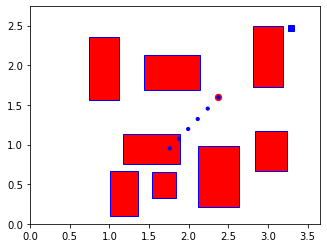

In [152]:
Xopt = optvals[0]
obstacles = []
for ii_obs in range(n_obs):
    obs = train_data[0]['obstacles'][idx][:,ii_obs]
    # obs = prob_params['obstacles'][:,ii_obs]
    obstacles.append(obs)

x0 = prob_params['x0']
xg = prob_params['xg']

# x0 = findIC(obstacles, posmin, posmax, velmin, velmax)
# x0 = prob_params['x0']

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='red',ec="red")
    plt.gca().add_patch(circle)


    plt.plot(xg[0],xg[1],'sb')
    # plt.quiver(Xopt[0,:], Xopt[1,:], Xopt[2,:], Xopt[3,:])#用箭头表示#
    for jj in range(N):
        circle = plt.Circle((Xopt[0,jj],Xopt[1,jj]), 0.02, fc='blue',ec="blue")
        plt.gca().add_patch(circle)

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

In [153]:
from pytorch.models import FFNet
import random
import time
from torch import optim

ff_shape=[]
for ii in range(3):
    ff_shape.append(128)
ff_shape.append(OMISTL_obj.n_strategies)
ff_shape.insert(0, OMISTL_obj.n_features)
len(ff_shape)


layers = []
for ii in range(0,len(ff_shape)-1):
    layers.append(torch.nn.Linear(ff_shape[ii],ff_shape[ii+1]))

layers = torch.nn.ModuleList(layers)


rand_idx = list(np.arange(0,X.shape[0]-1))
random.shuffle(rand_idx)

bz=64
for ii in range((len(rand_idx) + bz - 1) // bz):
    indices = rand_idx[ii * bz:(ii + 1) * bz]


for ii,idx in enumerate(indices):
    labels = Variable(torch.from_numpy(Y[idx])).long().to(device=OMISTL_obj.device)
    ff_inputs = Variable(torch.from_numpy(X[idx,:])).float().to(device=OMISTL_obj.device)
    # print(labels)
    # print(ff_inputs)
    # outputs = coco_obj.model(ff_inputs)


training_loss = torch.nn.CrossEntropyLoss()
# outputs=torch.unsqueeze(outputs,0)

# class_guesses = torch.argmax(outputs, 1)
inpt=Variable(torch.from_numpy(OMISTL_obj.features)).unsqueeze(0).float()


OMISTL_obj.model.to(device=torch.device('cpu'))
with torch.no_grad():
    scores = OMISTL_obj.model(inpt).cpu().detach().numpy()[:].squeeze()


OMISTL_obj.n_evals=4
ind_max = np.argsort(scores, axis=1)[:,-OMISTL_obj.n_evals:][:,::-1]
# # outputs
# func=torch.nn.CrossEntropyLoss()
# a=torch.Tensor([[ 0.0606,0.1610,0.2990,0.2101, 0.5104],
#                 [0.6388,0.4053, 0.4196, 0.7060, 0.2793],
#                 [ 0.3973,0.6114, 0.1127, 0.7732, 0.0592]])
# b=[3,1,0]
# #
# b=torch.Tensor(b)
# loss=func(a,b.long())
# loss=func(a,b.long())
# print("总loss:",loss)

obs_strats = {}
uniq_idxs = np.unique(ind_max)
uniq_idxs

TypeError: forward() missing 1 required positional argument: 'feature_batch'

In [41]:
ind_max

array([[351, 304, 385, 308],
       [351, 304, 308, 385],
       [351, 308, 304, 385],
       ...,
       [351, 308, 304,  77],
       [351, 308, 304,  77],
       [351, 308, 304, 385]], dtype=int64)

In [12]:
obs_strats = {}
uniq_idxs = np.unique(ind_max)

for ii,idx in enumerate(uniq_idxs):
    for jj in range(OMISTL_obj.labels.shape[0]):
        # first index of training label is that strategy's idx
        label = OMISTL_obj.labels[jj]
        if label[0] == idx:
            # remainder of training label is that strategy's binary pin
            obs_strats[idx] = label[1:]


In [13]:
import  itertools
vv = [np.arange(0,OMISTL_obj.n_evals) for _ in range(OMISTL_obj.problem.n_obs)]
strategy_tuples = list(itertools.product(*vv))#创建combaination list, 大小为n_eval**n_obs#
strategy_tuples

[(0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 1),
 (0, 0, 0, 0, 0, 0, 0, 2),
 (0, 0, 0, 0, 0, 0, 0, 3),
 (0, 0, 0, 0, 0, 0, 1, 0),
 (0, 0, 0, 0, 0, 0, 1, 1),
 (0, 0, 0, 0, 0, 0, 1, 2),
 (0, 0, 0, 0, 0, 0, 1, 3),
 (0, 0, 0, 0, 0, 0, 2, 0),
 (0, 0, 0, 0, 0, 0, 2, 1),
 (0, 0, 0, 0, 0, 0, 2, 2),
 (0, 0, 0, 0, 0, 0, 2, 3),
 (0, 0, 0, 0, 0, 0, 3, 0),
 (0, 0, 0, 0, 0, 0, 3, 1),
 (0, 0, 0, 0, 0, 0, 3, 2),
 (0, 0, 0, 0, 0, 0, 3, 3),
 (0, 0, 0, 0, 0, 1, 0, 0),
 (0, 0, 0, 0, 0, 1, 0, 1),
 (0, 0, 0, 0, 0, 1, 0, 2),
 (0, 0, 0, 0, 0, 1, 0, 3),
 (0, 0, 0, 0, 0, 1, 1, 0),
 (0, 0, 0, 0, 0, 1, 1, 1),
 (0, 0, 0, 0, 0, 1, 1, 2),
 (0, 0, 0, 0, 0, 1, 1, 3),
 (0, 0, 0, 0, 0, 1, 2, 0),
 (0, 0, 0, 0, 0, 1, 2, 1),
 (0, 0, 0, 0, 0, 1, 2, 2),
 (0, 0, 0, 0, 0, 1, 2, 3),
 (0, 0, 0, 0, 0, 1, 3, 0),
 (0, 0, 0, 0, 0, 1, 3, 1),
 (0, 0, 0, 0, 0, 1, 3, 2),
 (0, 0, 0, 0, 0, 1, 3, 3),
 (0, 0, 0, 0, 0, 2, 0, 0),
 (0, 0, 0, 0, 0, 2, 0, 1),
 (0, 0, 0, 0, 0, 2, 0, 2),
 (0, 0, 0, 0, 0, 2, 0, 3),
 (0, 0, 0, 0, 0, 2, 1, 0),
 

In [14]:
import  itertools
# obs_strats
vv = [np.arange(0,coco_obj.n_evals) for _ in range(coco_obj.problem.n_obs)]
strategy_tuples = list(itertools.product(*vv))

max_evals=16
probs_str = [1./(np.sum(st)+1.) for st in strategy_tuples]  # lower sum(st) values --> better
probs_str = probs_str / np.sum(probs_str)
str_idxs = np.random.choice(np.arange(0,len(strategy_tuples)), max_evals, p=probs_str)
str_idxs


if 0 in str_idxs:
    str_idxs = np.unique(np.insert(str_idxs, 0, 0))
else:
    str_idxs = np.insert(str_idxs, 0, 0)[:-1]

strategy_tuples = [strategy_tuples[ii] for ii in str_idxs]
strategy_tuples

[(0, 0, 0, 0, 0, 0, 0, 0),
 (1, 3, 0, 1, 1, 1, 2, 3),
 (0, 2, 1, 3, 1, 2, 3, 0),
 (2, 3, 2, 0, 3, 1, 3, 1),
 (3, 0, 0, 1, 2, 1, 0, 2),
 (1, 3, 1, 1, 1, 1, 1, 2),
 (0, 2, 2, 1, 1, 2, 2, 0),
 (1, 1, 0, 0, 3, 3, 1, 2),
 (1, 3, 0, 1, 3, 0, 3, 3),
 (2, 3, 3, 1, 1, 0, 2, 3),
 (1, 3, 2, 0, 3, 1, 0, 0),
 (1, 3, 1, 3, 1, 2, 0, 2),
 (3, 0, 0, 2, 0, 0, 3, 0),
 (0, 2, 0, 0, 3, 2, 3, 0),
 (0, 2, 2, 0, 3, 3, 3, 0),
 (0, 0, 2, 1, 1, 2, 1, 3)]